<a href="https://colab.research.google.com/github/VintageGold/Text_Summarization/blob/main/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

%cd drive/My \ Drive/Text_Summarization

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My  Drive/Text_Summarization


In [2]:
import json
import pandas as pd

# Load Data

In [3]:
with open("Data/Telehealth_article_texts.txt") as f:
    #Skip header
    for i in range(4):
        next(f) 
    corpus = f.read()

In [4]:
dict_articles = json.loads(corpus.replace("\n",""))

In [5]:
df_articles = pd.DataFrame.from_dict(dict_articles,orient="index",columns=["Content"]).reset_index().drop(columns=["index"])

In [6]:
df_articles.head()

,Content
0,Veterans face a variety of stressors related t...
1,The impact of the COVID-19 pandemic on the chi...
2,"In November 2019, COVID-19—the infectious, hig..."
3,Anxiety and depressive disorders are among the...
4,"In mid-March, 2020, the authors—as well as the..."


In [7]:
df_metadata = pd.read_excel("Data/Metadata_telehealth_article_key_2.25.xlsx",sheet_name="Tied_to_Notebook",index_col="Index")
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation
Index,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea..."
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca..."
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar..."
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)...."


In [8]:
#Ensure Both Indexes are of same type before merge
assert df_metadata.index.dtype == df_articles.index.dtype

#Merge dataframes
df_metadata = df_metadata.merge(df_articles,left_index=True,right_index=True,how="left")

In [9]:
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content
Index,,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the..."


In [10]:
df_metadata.dtypes

Journal Title     object
Article Title     object
Date Published     int64
Authors           object
Abstract          object
Keywords          object
Citation          object
Content           object
dtype: object

# Clean Data
1.   Lowercase
2.   Remove Punctuation
3.   White Spaces



In [11]:
import string

In [21]:
def clean_text(text,lowercase=True,tokenized=True):
    
    corpus =  text
    
    if lowercase:
        corpus = text.lower()

    translator = str.maketrans("","",string.punctuation + "\n" + "\tb")
    
    clean_corpus = corpus.translate(translator)
    
    remove_extra_whitespaces = [token.strip() for token in clean_corpus.split()]

    return ' '.join(remove_extra_whitespaces)





In [22]:
df_metadata['Content_Clean'] = df_metadata['Content'].apply(lambda text: clean_text(text,lowercase=True))
df_metadata['Content_Length'] = df_metadata['Content_Clean'].apply(lambda text: len(text))
df_metadata['Abstract_Length'] = df_metadata['Abstract'].apply(lambda text: len(str(text)))
df_metadata["Parsed_Keywords"] = df_metadata["Keywords"].apply(lambda keywords: str(keywords).replace("\n\n"," ").split(" ")[1:])
df_metadata['Parsed_Keywords_Length'] = df_metadata['Parsed_Keywords'].apply(lambda text: len(text))


In [23]:
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Clean,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length
Index,,,,,,,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,veterans face a variety of stressors related t...,35996,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,the impact of the covid19 pandemic on the chil...,71152,1577,"[remote, child, custody, evaluations,, videoco...",10
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",in novemer 2019 covid19—the infectious highly ...,60855,1842,"[forensic, e-mental, health,, telehealth,, tel...",8
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,anxiety and depressive disorders are among the...,29089,1650,"[education, and, training,, telepsychology,, C...",6
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",in midmarch 2020 the authors—as well as the ma...,40983,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6


# Text Mining - frequency counts of words, length of sentences, presence/absence of specific words

In [24]:
import matplotlib
import matplotlib.pyplot as plt
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer, DispersionPlot, PosTagVisualizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


matplotlib.rcParams["figure.figsize"] = (20, 7)

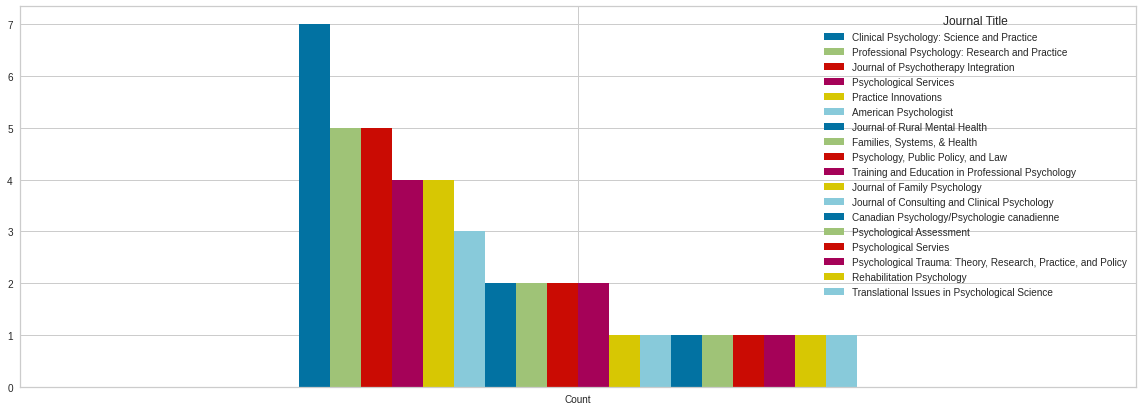

In [25]:
df_metadata[["Journal Title","Content"]].rename(columns={"Content":"Count"}).groupby("Journal Title").count().sort_values("Count",ascending=False).T.plot(kind="bar")

_ = plt.xticks(rotation=360)

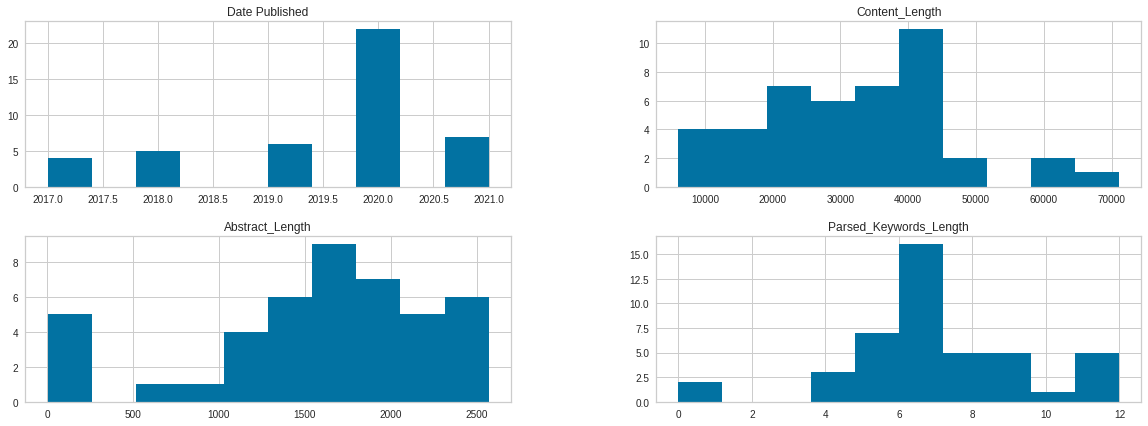

In [26]:
_ = df_metadata.hist()

In [27]:
# There are not strong linear correlations between the lengths or Date Published
df_metadata.corr()

,Date Published,Content_Length,Abstract_Length,Parsed_Keywords_Length
Date Published,1.000000,0.210964,0.340628,-0.171761
Content_Length,0.210964,1.000000,0.401089,0.249972
Abstract_Length,0.340628,0.401089,1.000000,0.088227
Parsed_Keywords_Length,-0.171761,0.249972,0.088227,1.000000


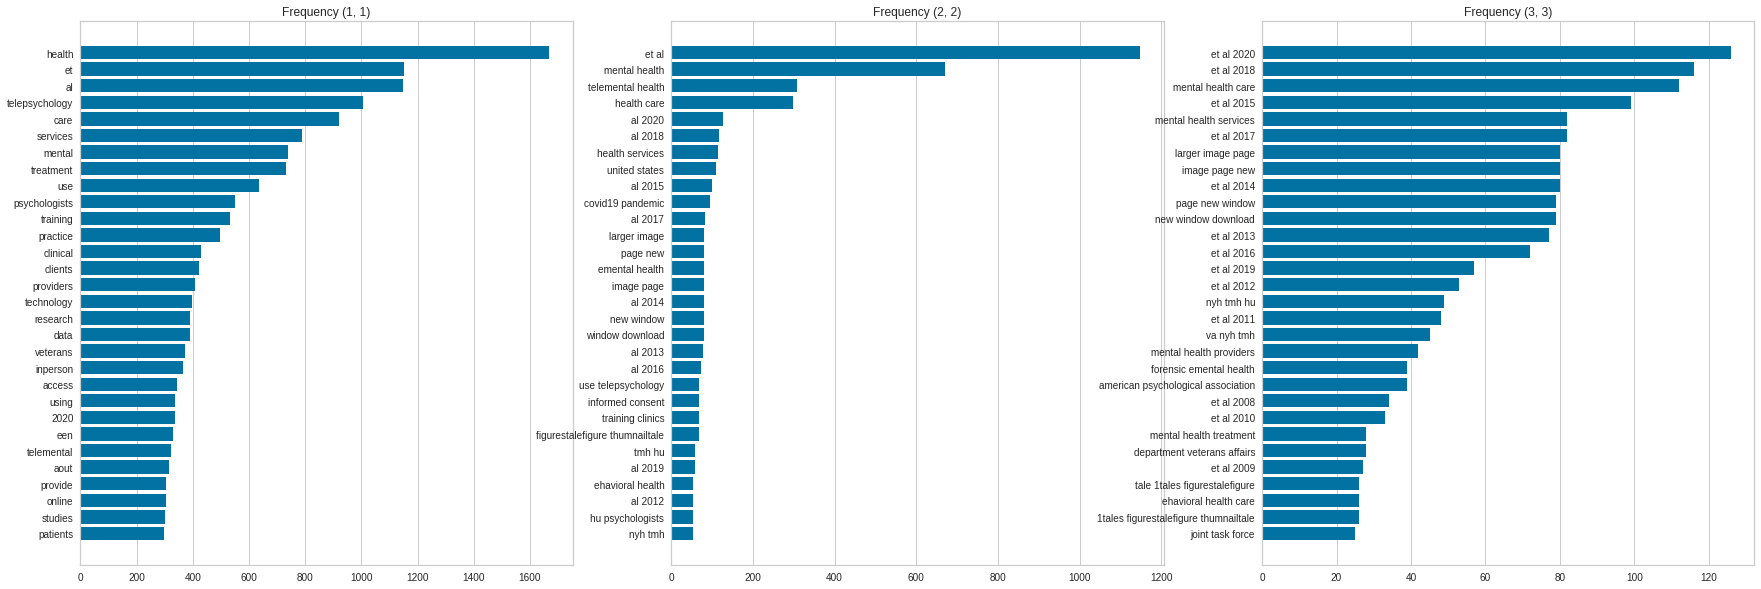

In [28]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1,3,figsize=(30,10))

figs = len(ax)

for i in range(figs):

    vectorizer = CountVectorizer(stop_words="english",ngram_range=(i+1,i+1))
    docs = vectorizer.fit_transform(text for text in df_metadata["Content_Clean"])
    features = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(features=features, orient="H",n=30,ax=ax[i])
    ax[i].set_title(f"Frequency {vectorizer.ngram_range}")
    _ = visualizer.fit(docs)

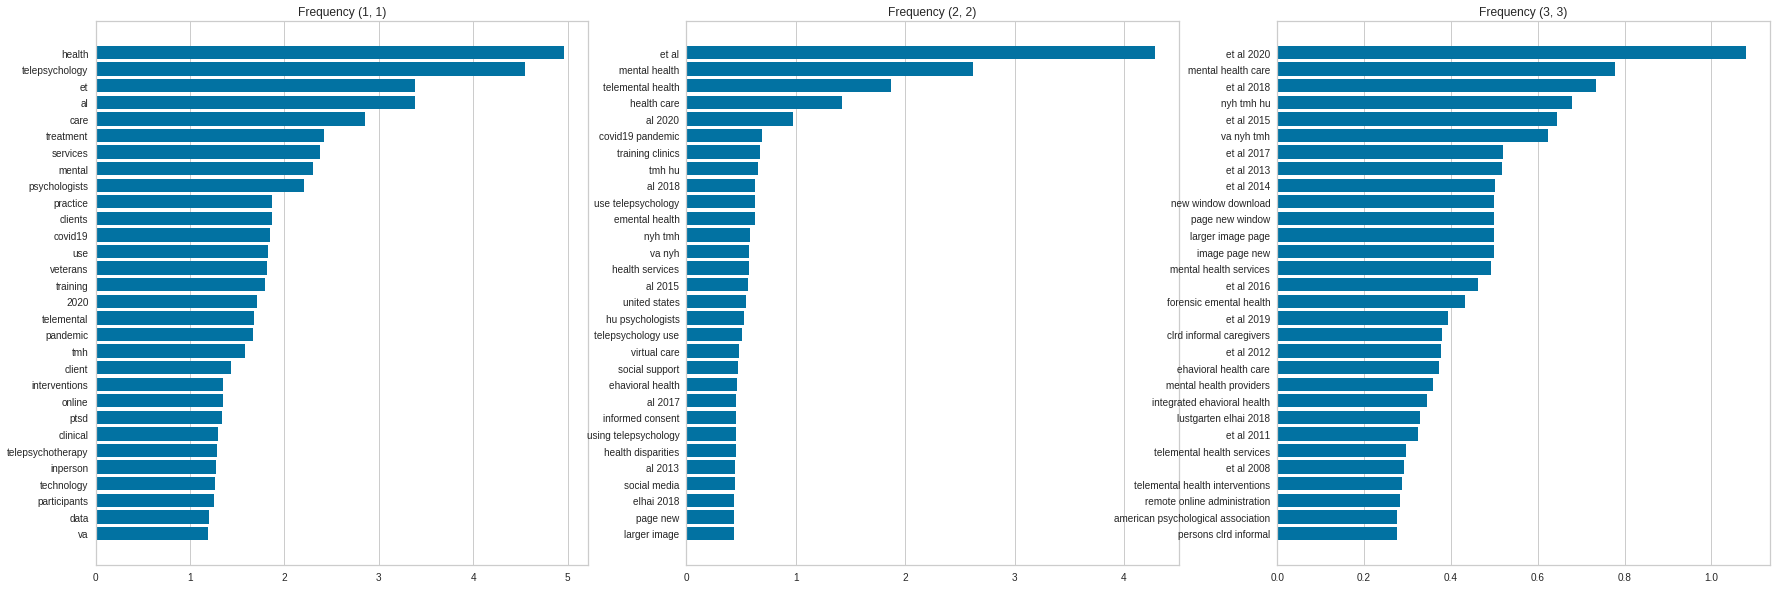

In [29]:
fig, ax = plt.subplots(1,3,figsize=(30,10))

figs = len(ax)

for i in range(figs):

    vectorizer = TfidfVectorizer(stop_words="english",ngram_range=(i+1,i+1))
    docs       = vectorizer.fit_transform(text for text in df_metadata["Content_Clean"])
    features   = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(features=features, orient="H",n=30,ax=ax[i])
    ax[i].set_title(f"Frequency {vectorizer.ngram_range}")
    _ = visualizer.fit(docs)

## NLP - Natural Language Processing is one of the components of text mining NLP helps identify sentiments, find entities in the sentence and categories of blogs/articles/posts

## In text analytics, statistical and machine learning algorithms are primarily used to (1) classify, cluster,and summarize information, (2) to perform sentiment analysis, entity extraction and recognition, as well as similarity analysis and relation modeling